# **PARAMETER FITTING DETAILED EXAMPLE**

This provides a detailed example of parameter fitting using the python-based tool ``SBstoat``. 
Details about the tool can be found at in this [github repository](https://github.com/sys-bio/SBstoat).

# Preliminaries

In [1]:
!pip install -q SBstoat
!pip install -q tellurium

In [2]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

# Helpers

In [3]:
MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""

In [4]:
def plotTS(ts, title=""):
    """
    Plots columns in a timeseries.
    
    Parameters
    ----------
    ts: NamedTimeseries
    """
    p = plt.plot(ts[TIME], ts[ts.colnames])
    _ = plt.legend(p, ts.colnames, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = plt.title(title)

In [5]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
rr = te.loada(MODEL)
data = rr.simulate()
assert(isinstance(arrToDF(data), pd.DataFrame))
print("OK!")

OK!


In [6]:
def generateNoisyData(model, std, parameter_dct=None):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    model: str (Antimony model)
    std: float (standard deviation of generated noise)
    parameter_dct: dict (parameters to change)
    
    Returns
    ------
    DataFrame
    """
    if parameter_dct is None:
        parameter_dct = {}
        #
    rr = te.loada(model)
    for key, value in parameter_dct.items():
        rr[key] = value
    df = arrToDF(rr.simulate())
    ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, 0.2, len(noise_df))
        noise_df[column] = ser.loc[column]*noise_arr 
    return noise_df + df

# Tests
df = generateNoisyData(MODEL, 0, parameter_dct={"k": 3})
assert(isinstance(df, pd.DataFrame))
assert(len(df) > 0)
print("OK!")

OK!


# Fitting with SBstoat

``SBstoat`` is a python package intended to simplify the programmatic aspects of fitting. The package provides handles the programming details
of the interactions between the optimization codes (``lmfit``) and ``tellurium`` simulations.

The required inputs to ``SBstoat`` are:
- the model for which parameter values are being estimated;
- observational data; and
- specification of the parameters, their value ranges, and initial values.

For the linear pathway model, we ``LINEAR_PATHWAY_MODEL`` and ``LINEAR_PATHWAY_DF`` for the model and data, respectively.
The description of the paarameters is done using a python dictionary, as shown below.

In [7]:
MODEL2 = """
R1:  S1 -> S2; k1*S1  
R2: S2 + S1 -> S3; k2*S2*S1
R3: S3 -> S4 + S1; k3*S3
R4: S4 + S1 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
k3 = 0; # Nominal value of parameter
k4 = 0; # Nominal value of parameter
"""

## Parameters

In [8]:
# Name, minimal value, initial value, and maximum value of each parameter
PARAMETERS = [
    SBstoat.Parameter("k1", lower=1, value=5, upper=10),
    SBstoat.Parameter("k2", lower=1, value=5, upper=10),
    SBstoat.Parameter("k3", lower=1, value=5, upper=10),
    SBstoat.Parameter("k4", lower=1, value=5, upper=10),
]

## Observational Data

<AxesSubplot:xlabel='time'>

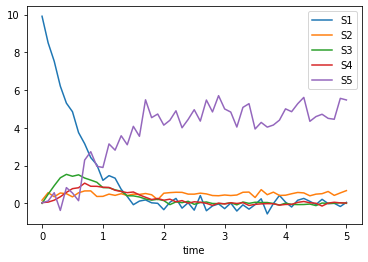

In [9]:
# Generate synthetic data
parameter_dct = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
df = generateNoisyData(MODEL2, 0.2, parameter_dct=parameter_dct)
OBSERVED_TS = NamedTimeseries(dataframe=df)
OBSERVED_TS.to_dataframe().plot()

## Running a fit

In [10]:
fitter1 = ModelFitter(MODEL2, OBSERVED_TS, parametersToFit=PARAMETERS,
                    fitterMethods=["differential_evolution"])
fitter1.fitModel()
print(fitter1.reportFit())

[[Variables]]
    k1:  1.0000002325073154
    k2:  1.9817788066881301
    k3:  3.0740277836012893
    k4:  4.020489780086112
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1220
    # data points      = 255
    # variables        = 4
    chi-square         = 17.6444870
    reduced chi-square = 0.07029676
    Akaike info crit   = -673.064242
    Bayesian info crit = -658.899187
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


The report is in three sections.

The first section contains measures of the fit quality. The most commonly used measures are chi-square and reduced chai-square.
We want both of these to be "small", although small is relative.
These measures are most useful when comparing different fit results.

The "Variables" section gives parameter estimates. We se that the estimates obtained are fairly close to
the true values in the original models.

The final section provides information about the relationships between parameter estimates. This can be useful
in models where the structure of the model makes it difficult to separate one parameter from another.
In these cases, there will be a large correlation between parameter (absolute) parameter values.

In [11]:
fitter2 = ModelFitter(MODEL2, OBSERVED_TS, parametersToFit=PARAMETERS,
                    fitterMethods=["leastsquares"])
fitter2.fitModel()
print(fitter2.reportFit())

[[Variables]]
    k1:  1.0000000528810575
    k2:  1.9819325821010318
    k3:  3.073489366330334
    k4:  4.02234042126063
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 255
    # variables        = 4
    chi-square         = 17.6444925
    reduced chi-square = 0.07029678
    Akaike info crit   = -673.064162
    Bayesian info crit = -658.899108
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.356
    C(k2, k3) = -0.165


## More detailed analyses of fits

``SBstoat`` provides many plots to aid in understanding the fitting results.
You can see these by typing in a Jupyter code cell ``fitter.pl`` and then pressing the tab key.
Arguably the most useful is ``plotFitAll``, which, for each floating species (column in observed data), plots the fitted and observed values.
This is shown below.

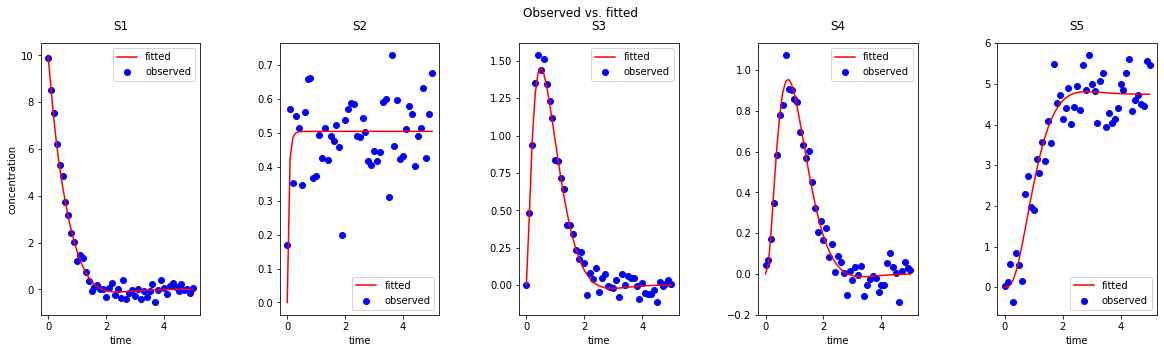

In [12]:
fitter1.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

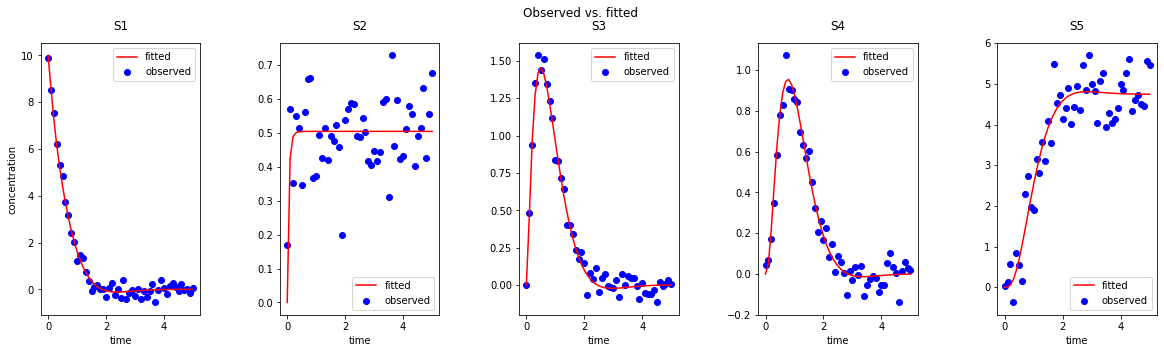

In [13]:
fitter2.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

In [14]:
# See the options for plotFitAll
?fitter1.plotFitAll

Signature:
fitter1.plotFitAll(
    params:lmfit.parameter.Parameters=None,
    numPoint:int=None,
    **kwargs,
)
Docstring:
Plots the fitted with observed data over time.

Parameters
----------

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
    (f) rows of plots
subplotWidthSpace: float
    (f) horizontal space between pl

If you are interested in a more complete analysis of the residuals, use ``plotResidualsAll``.

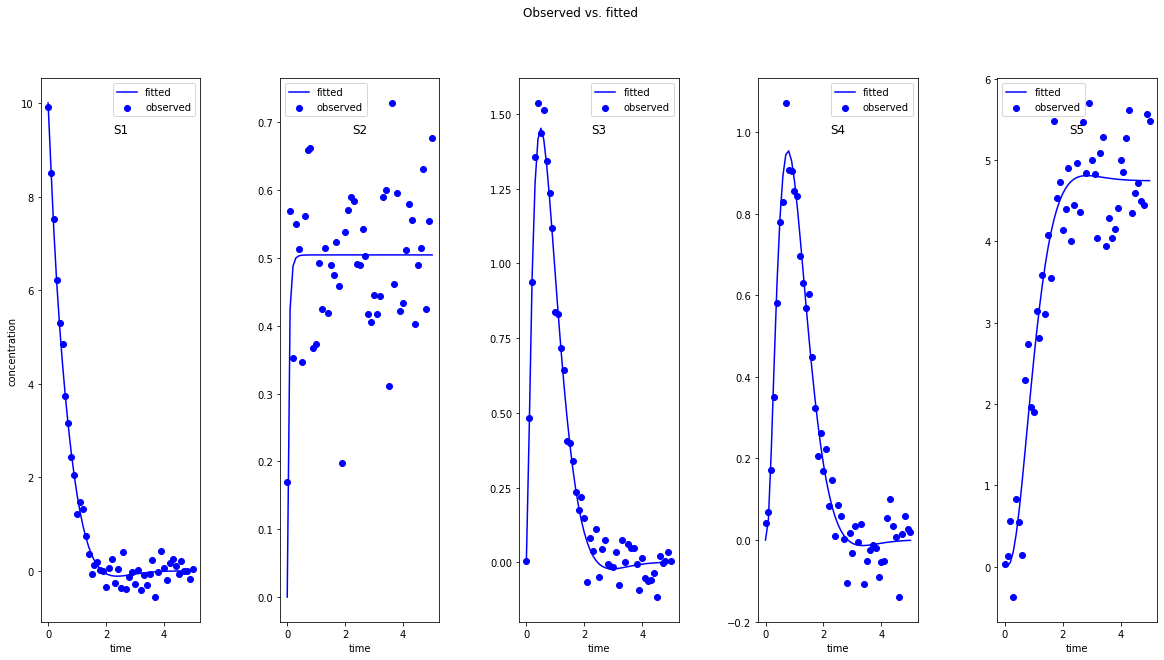

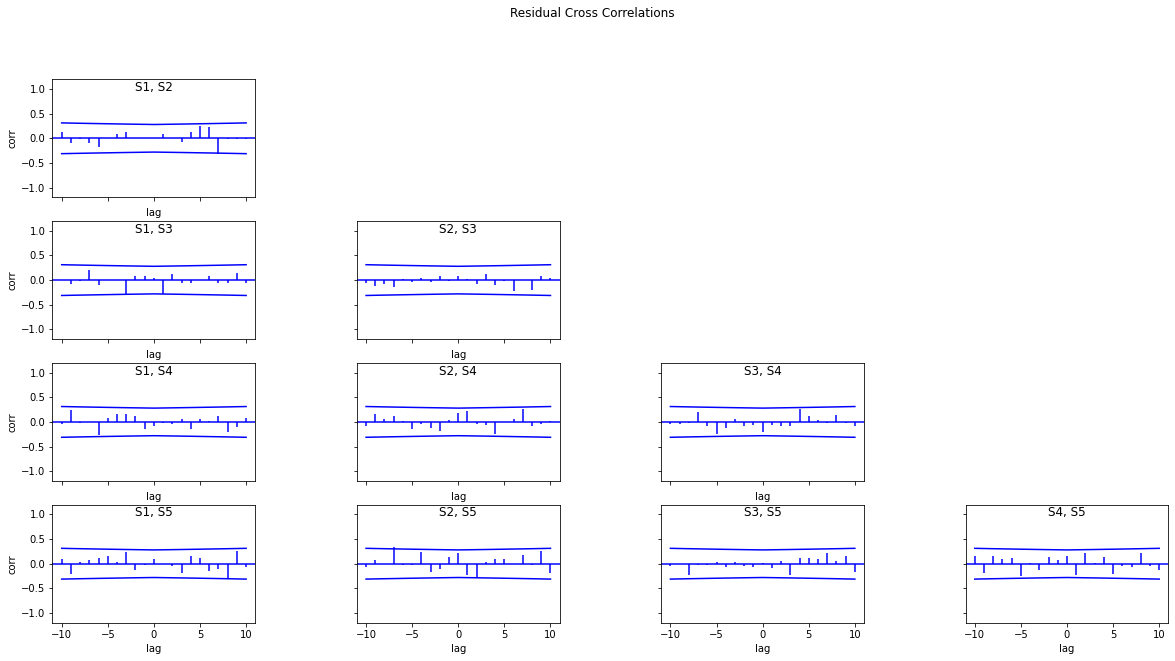

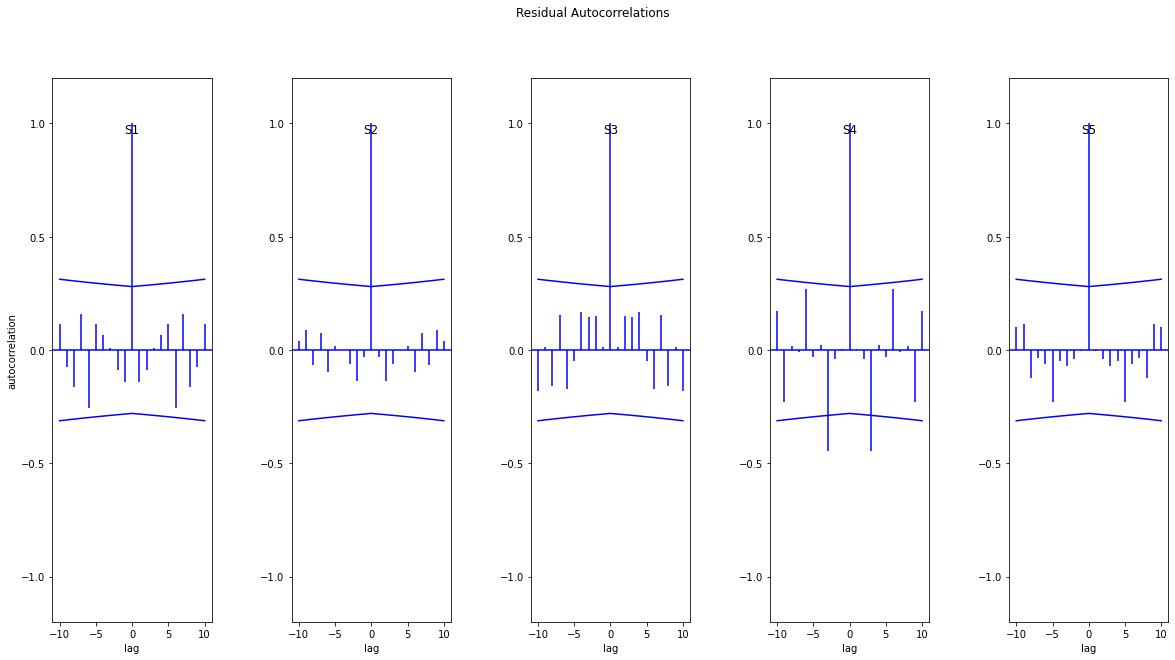

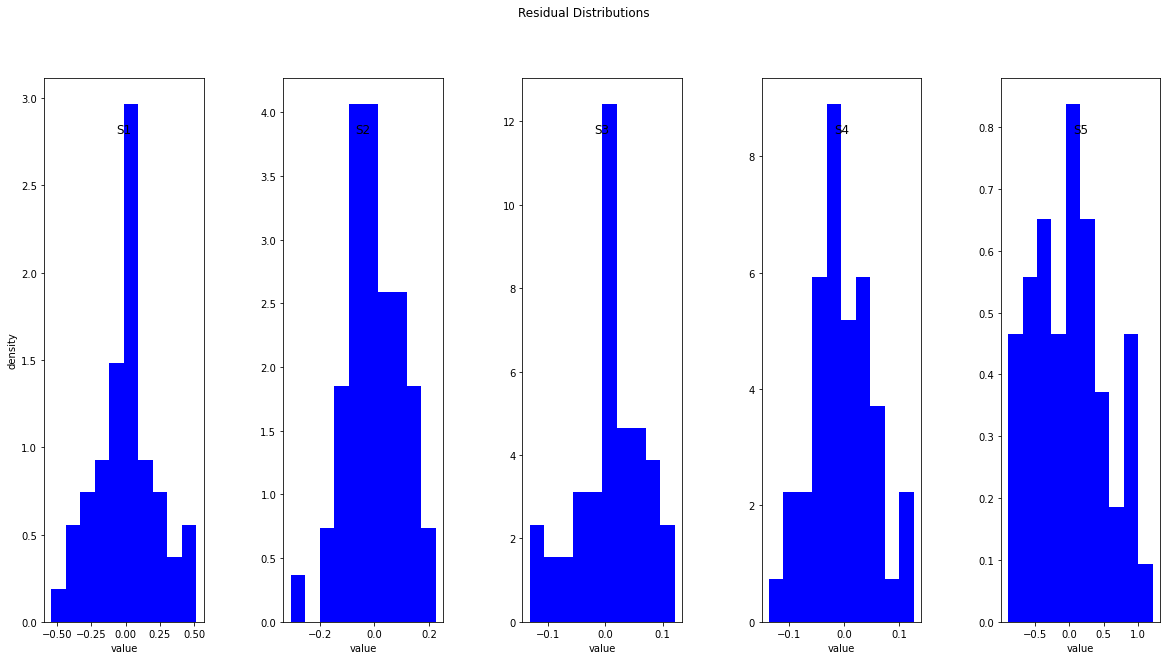

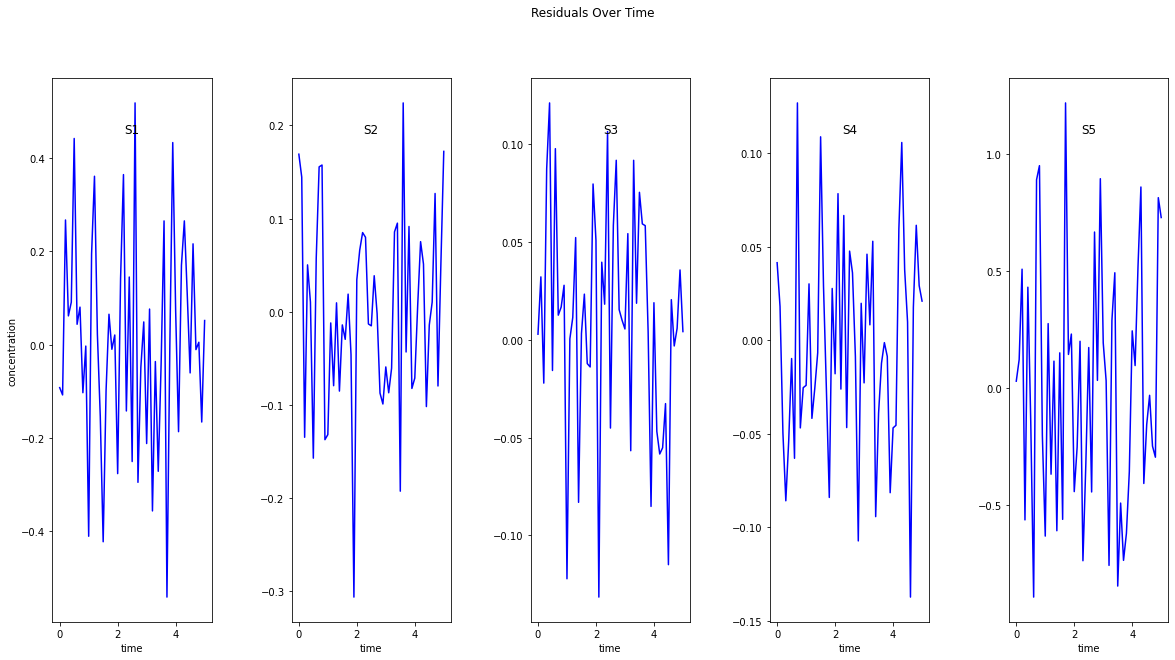

In [15]:
fitter1.plotResidualsAll(figsize=(20, 10))

# Workflow for fitting the Linear Pathway Model

Although ``SBstoat`` eliminates the burden of programming details, fitting is often complex.
This is because of the complexity of the fitting surface, as illustrated earlier in this chaper.
This section illustrates how to use ``SBstoat`` to explore complex fitting surfaces.

``SBstoat`` allows you to explore fitting along three dimensions.
1. **Optimization Algorithms**. As we noted previously, gradient descent is fast, but it only works well for convex fitting surfaces. We might want to try both gradient descent and differential evolution to see which works best for our model. Also, some optimization algorithms are stochastic, and so the search strategy may also choose to run
the same algorithm multiple times. Finally, it may be desirable to do multiple optimizations in succession, using the results of the $n-1$-st to be the starting point for the $n$-th.
1. **Search start** This refers to the initial values of parameter values.
1. **Search scope** This referes to the range of parameter values that are explored.


In the following explorations of the above dimensions of parameter fitting, we use the above workflow that consists of:
1. Select a subset of the observed data based on a specified time span (in this case, just ending time)
1. Construct a fitter for the linear pathway, observed data, columns to consider in fitting, the fitting methods, and parameter ranges/initial values.
1. Fit the model.
1. Print the fitting report.
1. Plot observed and fitted values.

This workflow is encapsulated in the the function ``doFit``.
The arguments of the function have default that reproduce the
results in the previous section.

In [16]:
def doFit(model=MODEL2,
          std=0.2,
          fitterMethods=["leastsq"], 
          parametersToFit=PARAMETERS,
          isTest=False):
    """
    Encapsulates the workflow to fit the linear pathway model.

    Parameters
    ----------
    selectedColumns: list-str
    endTime: int
    fitterMethods: list-str
    parametersToFit: list-SBstoat.Parameter
    isTest: bool
        Test mode

    Returns
    -------
    ModelFitter
    """
    PARAMETER_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
    timeseries = NamedTimeseries(generateNoisyData(model, std, parameter_dct=PARAMETER_DCT))
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, timeseries,
                         fitterMethods=fitterMethods, 
                         parametersToFit=parametersToFit)
    fitter.fitModel()
    if not isTest:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return fitter

# TESTS
result = doFit(isTest=True, fitterMethods=["differential_evolution"])
assert(isinstance(result, ModelFitter))
print("OK")

OK


[[Variables]]
    k1:  1.0009368124000797
    k2:  2.4066718495954005
    k3:  2.7989180153702877
    k4:  3.3462149279021385
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 255
    # variables        = 4
    chi-square         = 38.3871172
    reduced chi-square = 0.15293672
    Akaike info crit   = -474.853116
    Bayesian info crit = -460.688062
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.365
    C(k1, k4) = -0.261
    C(k1, k2) = -0.135
    C(k2, k4) =  0.114


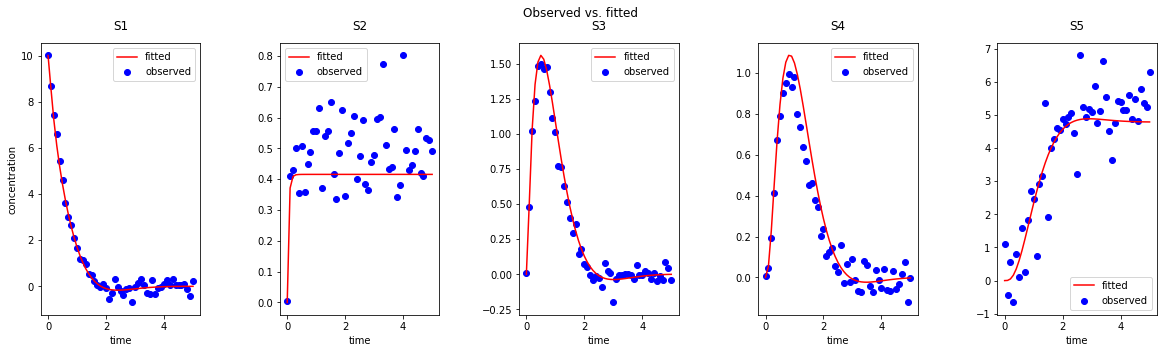

In [17]:
doFit()

We begin by exploring the effect of the fitting surface.

We can control the fitting surface in two ways. The first is by the selection of columns that are matched with observational data.

For example, suppose that we only consider ``S5`` and so the fitting surface is residuals
from fitting ``S5``.

In [18]:
doFit(selectedColumns=["S5"])

TypeError: doFit() got an unexpected keyword argument 'selectedColumns'

We see that we get poor estimates for most of the parameters, something that we can check because we know the true values of the parameters (``k1=1``, ``k2=2``, ``k3=3``, ``k4=4``).

Another consideration is to focus on a subset of the dynamics. Below, we only consider through 2 seconds.

In [ ]:
doFit(endTime=2)

This improved the quality of the fit. We see this visually in the above plots and also in the significant reduction in chi-square. A lot of this improvement
is a result of not inluding regions of high variability in observed values for ``S5``.

## Optimization Algorithms

The main consideration here is the choice of optimization algorithms.
Any valid ``method`` for ``lmfit`` can be used, and multiple methods can be used in combination. We illustrate this below.

[[Variables]]
    k1:  1.0001001620186867
    k2:  1.8248876856172973
    k3:  3.3539990326501297
    k4:  5.462851637704274
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 255
    # variables        = 4
    chi-square         = 37.2962010
    reduced chi-square = 0.14859044
    Akaike info crit   = -482.204879
    Bayesian info crit = -468.039825
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.281
    C(k1, k4) = -0.279
    C(k2, k3) = -0.181
    C(k1, k3) = -0.162
    C(k1, k2) =  0.107


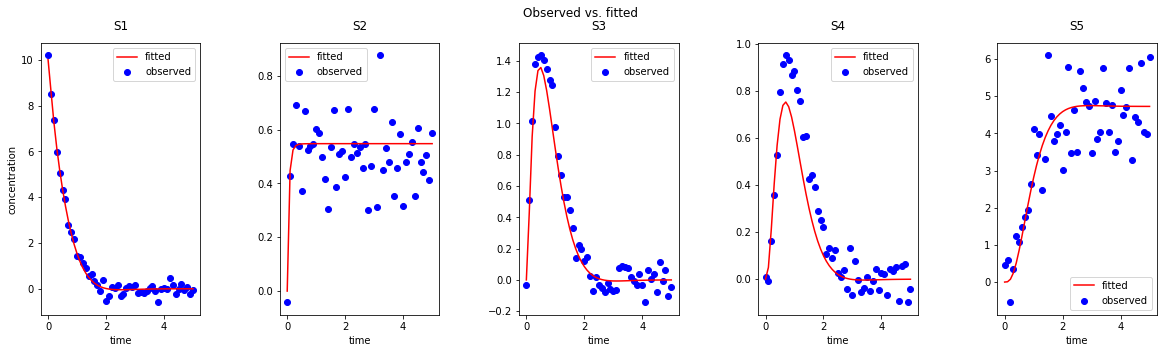

In [19]:
# Fit with Levenberg-Marquardt 
doFit(fitterMethods=["leastsq"])

[[Variables]]
    k1:  1.0231600903128855
    k2:  2.052904899123042
    k3:  3.021890966611212
    k4:  3.6286057582995612
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1260
    # data points      = 255
    # variables        = 4
    chi-square         = 33.3900876
    reduced chi-square = 0.13302824
    Akaike info crit   = -510.416139
    Bayesian info crit = -496.251085
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


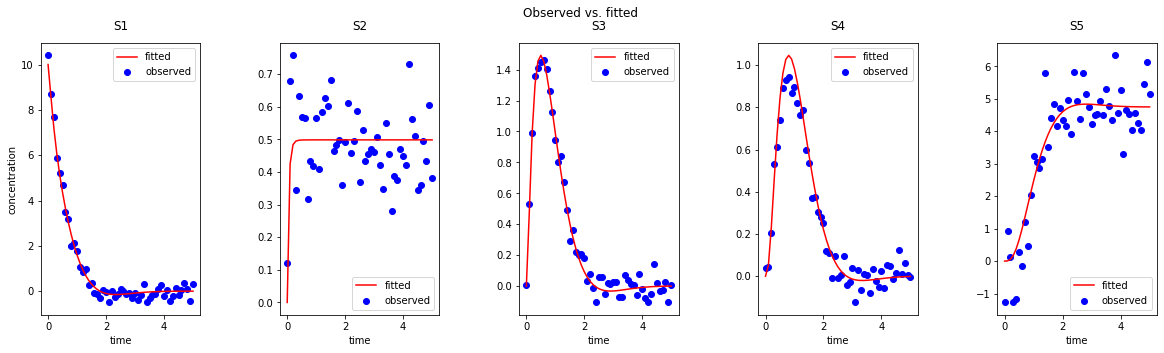

In [20]:
# Fit with differential evolution
doFit(fitterMethods=["differential_evolution"])

[[Variables]]
    k1:  1.0000000001128706
    k2:  2.1887615531955507
    k3:  3.2363268612714893
    k4:  4.3809164163575
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 255
    # variables        = 4
    chi-square         = 35.8441467
    reduced chi-square = 0.14280537
    Akaike info crit   = -492.331232
    Bayesian info crit = -478.166178
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k3) = -0.392
    C(k3, k4) = -0.304
    C(k2, k3) = -0.152


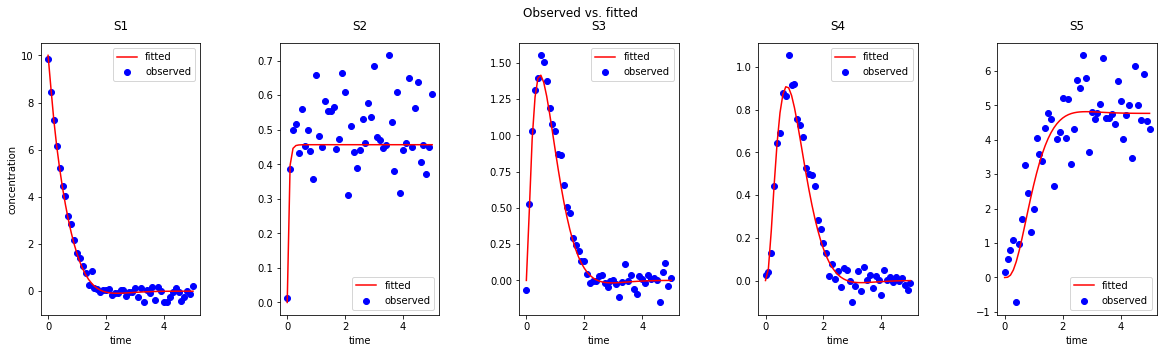

In [21]:
# Fit with differential evolution and then Levenberg-Marquardt 
doFit(fitterMethods=["differential_evolution", "leastsq"])

For this model, we see that Levenberg-Marquardt works better than differential evolution, and doing the two in combination offers no benefit.

## Search Start & Scope

Where we start the search and how far we search depends on the ranges of parameter values and the specification of initial values.
This is specified by the ``parameterDct`` argument to ``ModelFitter``. This argument defaults to ``LINEAR_PATHWAY_PARAMETER_DCT``.

If we create a bad parameter range, then we get very poor fits. Below, we start the search with a negative value for each parameter.
Note that the observed values appear to be constant because of the large scale of the fitted values.

[[Variables]]
    k1:  -1
    k2:  -1
    k3:  -1
    k4:  -1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 255
    # variables        = 4
    chi-square         = 2.3494e+12
    reduced chi-square = 9.3603e+09
    Akaike info crit   = 5858.70167
    Bayesian info crit = 5872.86673
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.951
    C(k1, k3) = -0.762
    C(k1, k4) =  0.752
    C(k1, k2) = -0.591
    C(k2, k4) = -0.535
    C(k2, k3) =  0.291


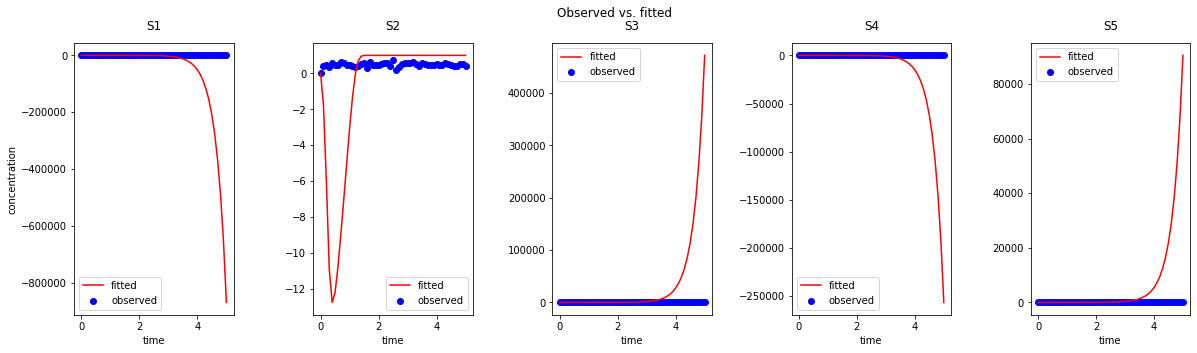

In [22]:
parametersToFit = [
    SBstoat.Parameter("k1", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k2", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k3", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k4", lower=-11, value=-1, upper=1),
    ]
doFit(parametersToFit=parametersToFit)

# Exercise

This exercise is about fitting parameters in the Wolf model for glycolytic oscillations.
The model is ``WOLF_MODEL`` and the observational data for this model are ``WOLF_DF``.

1. Implement a ``doFit`` function that encapsulates the workflow for the Wolf model.
1. Try fitting the model using ``WOLF_PARAMETERS``. First try ``leastSquares`` (a graident descent method) and then ``differential_evolution``. How did the two methods differ as to fitting time and quality? Why? What would you try next to get better fits?
1. Limit the parameter values so that the upper value is twice the true value. Try fits using leastsqs and differential evolution.